# <div class="alert alert-info"> 1. Introduction </div>

---
# <div class="alert alert-info"> 2. Setup </div>

 ## <font color=red>Import library</font>

In [151]:
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## for data
import collections
import json

import math
from math import exp
from scipy.stats import norm
import numpy.random as npr
import scipy.optimize as optimization

import yfinance as yf

## for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)

# display various ranges 
pd.options.display.float_format = '{:.3f}'.format

# Supress warnings
import warnings
warnings.filterwarnings("ignore")


---
# <div class="alert alert-info"> 3. DATA PREPARATION </div>

In [152]:
# on average there are 252 trading days in a year
NUM_TRADING_DAYS = 252
# we will generate random w (different portfolios)
NUM_PORTFOLIOS = 10000

# stocks we are going to handle
stocks = ['AAPL', 'WMT', 'GE', 'AMZN', 'IBM']

# historical data - define START and END dates
start_date = '2010-01-01'
end_date = '2017-01-01'


def download_data():
    # name  of the stock (key) - stock values (2010-2007) as the values
    stock_data = {}
    
    for stock in stocks:
        # closing prices
        ticker = yf.Ticker(stock)
        stock_data[stock] = ticker.history(start=start_date, end=end_date)['Close']
        
    return pd.DataFrame(stock_data)


def show_data(data):
    data.plot(figsize=(15,8))
    plt.show()
    


In [153]:
dataset = download_data()
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1762 entries, 2010-01-04 to 2016-12-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    1762 non-null   float64
 1   WMT     1762 non-null   float64
 2   GE      1762 non-null   float64
 3   AMZN    1762 non-null   float64
 4   IBM     1762 non-null   float64
dtypes: float64(5)
memory usage: 82.6 KB


In [154]:
df = dataset.copy()
df.head()

,AAPL,WMT,GE,AMZN,IBM
Date,,,,,
2010-01-04,6.535,40.658,87.554,6.695,83.321
2010-01-05,6.546,40.253,88.008,6.734,82.314
2010-01-06,6.442,40.163,87.554,6.613,81.780
2010-01-07,6.430,40.186,92.088,6.500,81.497
2010-01-08,6.473,39.983,94.071,6.676,82.314


---
# <div class="alert alert-info"> 3. PORTFOLIO THEORY </div>

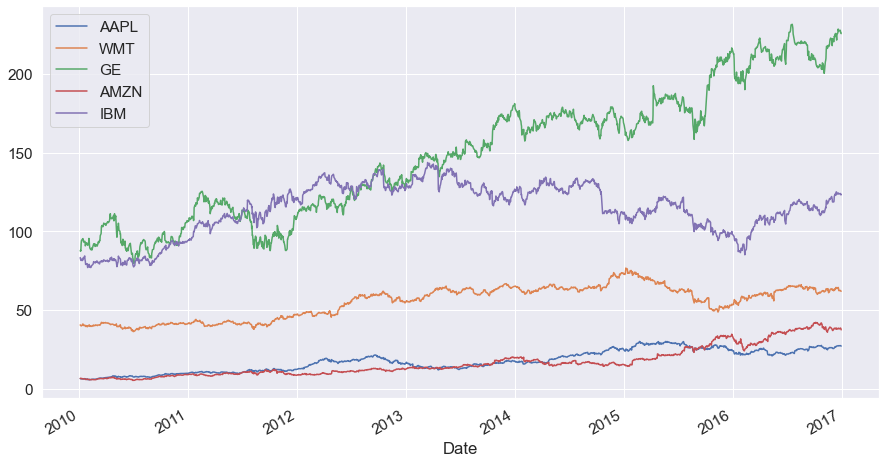

In [155]:
show_data(df)

 ## <font color=red> 4.1. Measuring Returns and Risk (Performance) of multiple assets

**Create a histogram of the daily returns for each stock in the portfolio:**

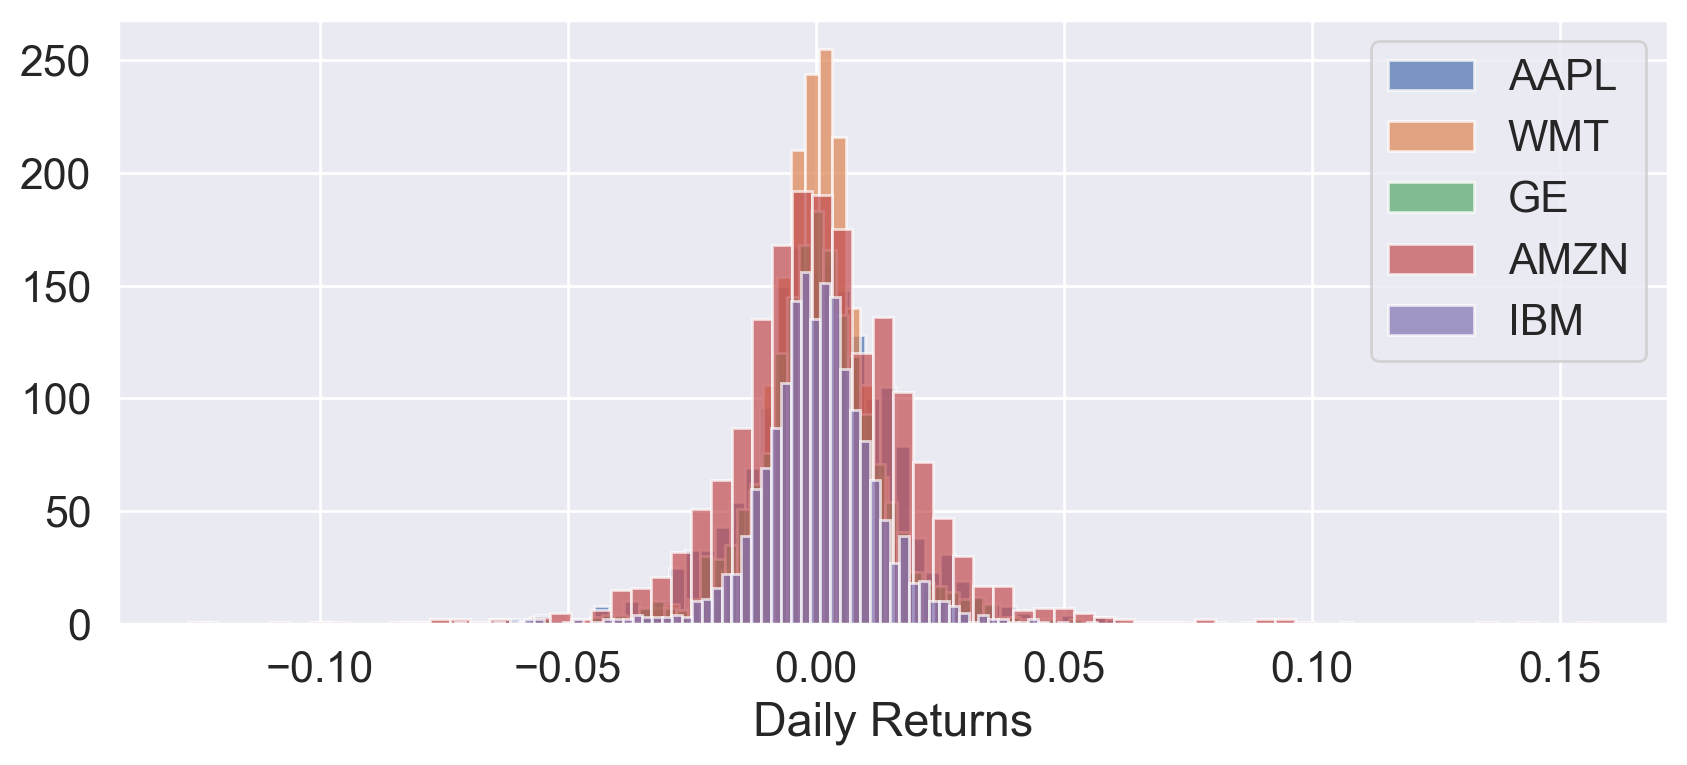

In [156]:
plt.figure(dpi=200, figsize=(10,4))
for stock_name in df.columns:
    df[stock_name].pct_change(1).hist(label=stock_name, alpha=0.7, bins=70)
    
plt.xlabel("Daily Returns")
plt.legend()

**Create a plot that shows the value of each stock at the start of the time series and what value it would have in dollars throughout the rest of the time period.**

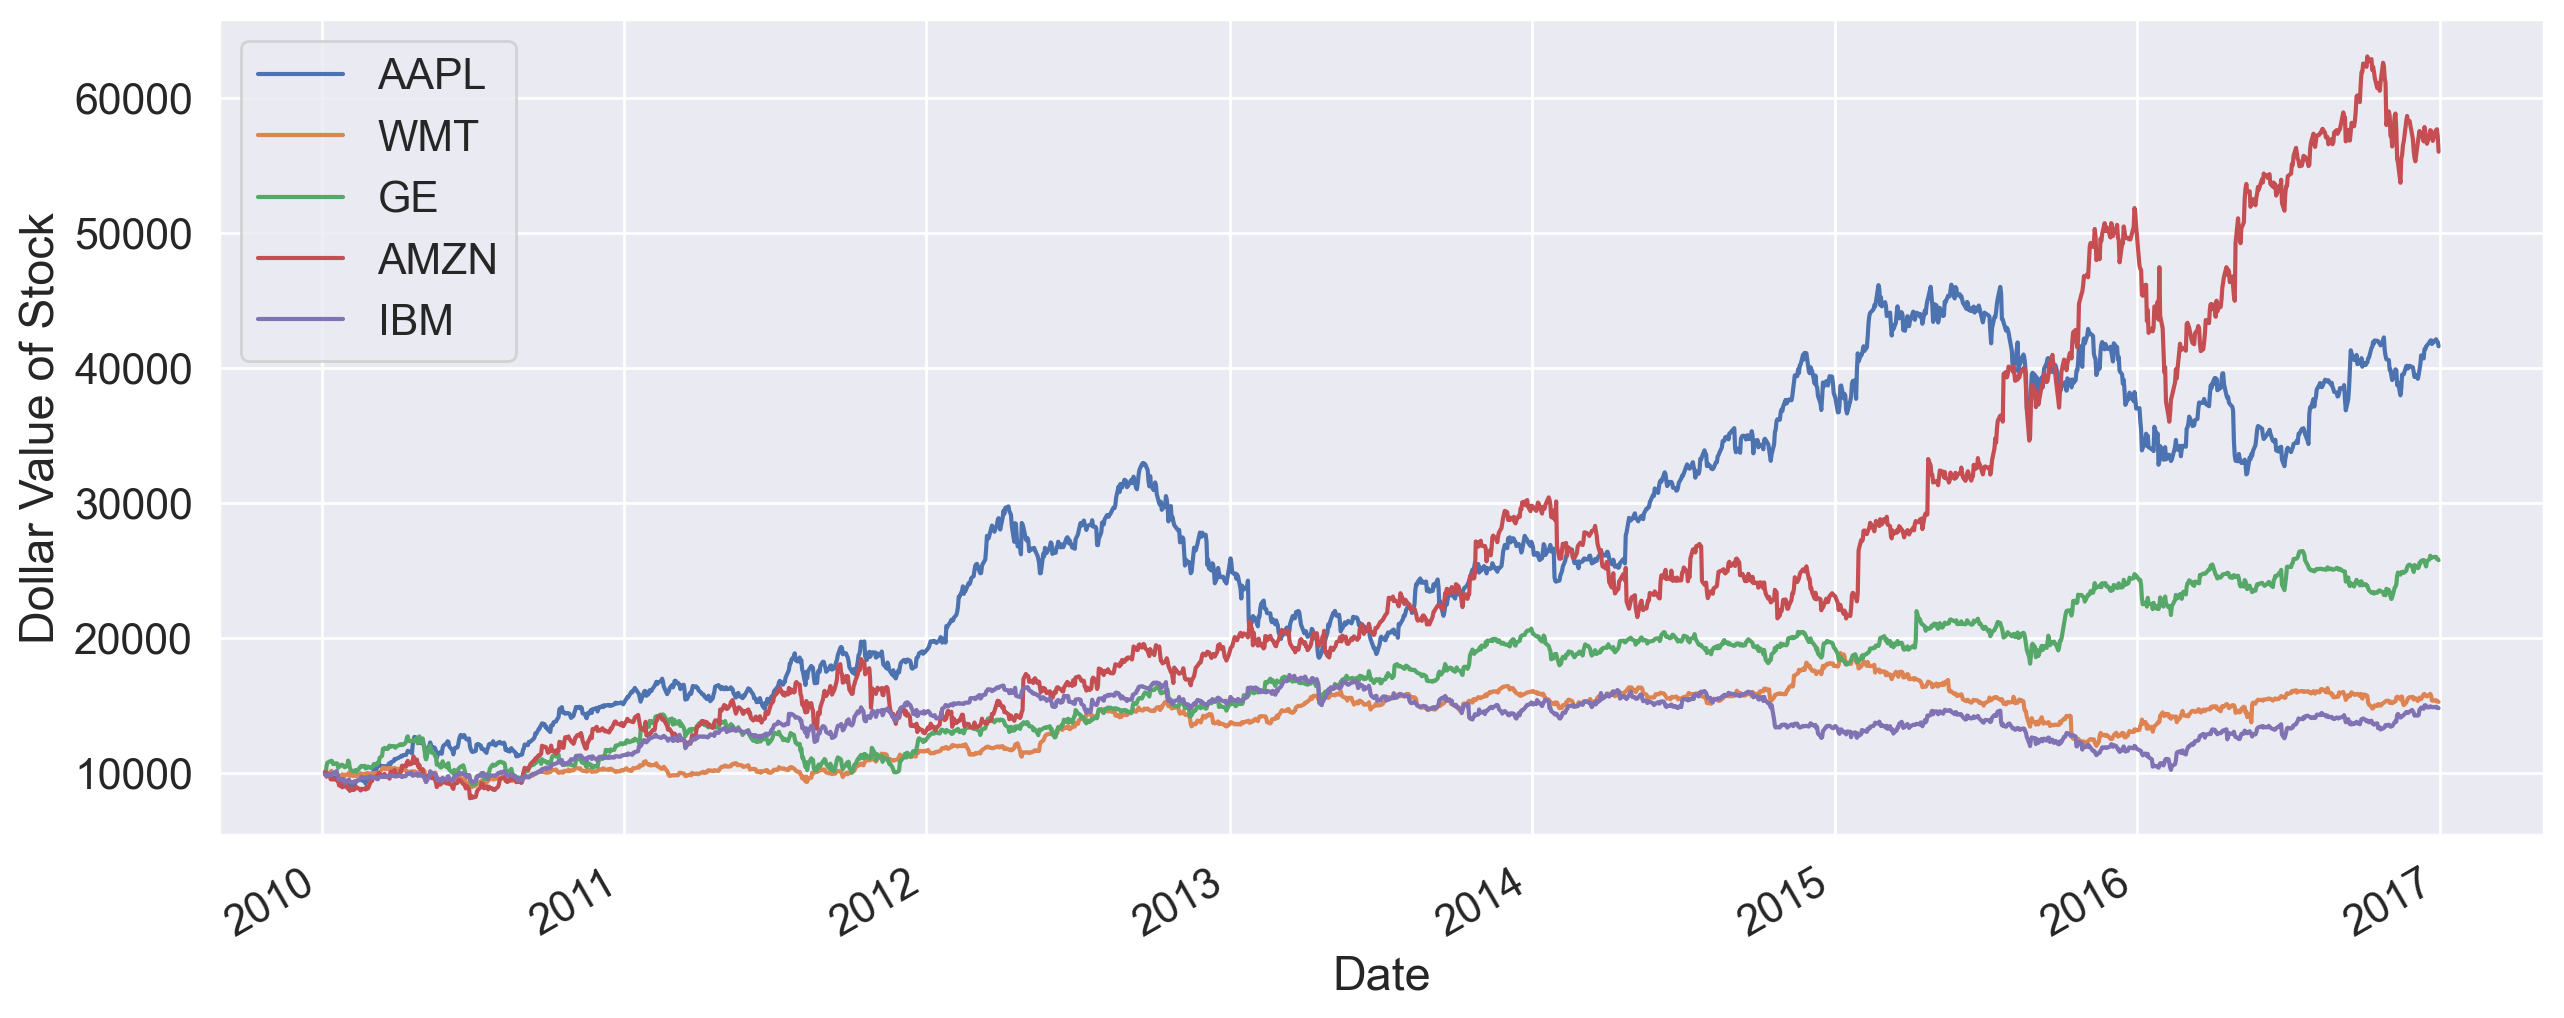

In [157]:
plt.figure(dpi=200, figsize=(15,6))

for stock_name  in df.columns:
    stock_rets = df[stock_name].pct_change(1)[1:]
    cumulative_ret = (stock_rets + 1).cumprod()
    stock_10000 = cumulative_ret * 10000
    stock_10000.plot();
    
plt.ylabel("Dollar Value of Stock")
plt.legend()

**Calculate the stocks percent rise or decline from any set of given dates**

In [158]:
def perc_calc(data,start_date,end_date):
    
    if start_date not in data.index or end_date not in data.index:
        return f"Start or End dates not in index of Series"
    
    adj_close_start = data[start_date]
    adj_close_end = data[end_date]
    change = 100*(adj_close_end-adj_close_start)/adj_close_start
    return f"Percent Change: {np.round(change,2)}%"

In [159]:
perc_calc(df['IBM'],'2010-01-04','2016-12-30')

'Percent Change: 47.83%'

#### Compare returns and risk

In [160]:
returns = df.apply(lambda x: np.log(x.dropna() / x.dropna().shift()))
returns.head()

,AAPL,WMT,GE,AMZN,IBM
Date,,,,,
2010-01-04,NaN,NaN,NaN,NaN,NaN
2010-01-05,0.002,-0.010,0.005,0.006,-0.012
2010-01-06,-0.016,-0.002,-0.005,-0.018,-0.007
2010-01-07,-0.002,0.001,0.050,-0.017,-0.003
2010-01-08,0.007,-0.005,0.021,0.027,0.010


In [161]:
returns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1762 entries, 2010-01-04 to 2016-12-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    1761 non-null   float64
 1   WMT     1761 non-null   float64
 2   GE      1761 non-null   float64
 3   AMZN    1761 non-null   float64
 4   IBM     1761 non-null   float64
dtypes: float64(5)
memory usage: 82.6 KB


In [162]:
returns.describe()

,AAPL,WMT,GE,AMZN,IBM
count,1761.000,1761.000,1761.000,1761.000,1761.000
mean,0.001,0.000,0.001,0.001,0.000
std,0.017,0.010,0.014,0.020,0.012
min,-0.132,-0.106,-0.068,-0.135,-0.086
25%,-0.007,-0.005,-0.006,-0.009,-0.006
50%,0.001,0.001,0.000,0.001,0.000
75%,0.010,0.006,0.008,0.012,0.007
max,0.085,0.091,0.103,0.146,0.055


In [163]:
summary = returns.agg(["mean", "std"]).T
summary

,mean,std
AAPL,0.001,0.017
WMT,0.000,0.010
GE,0.001,0.014
AMZN,0.001,0.020
IBM,0.000,0.012


   
__General Rule in Finance/Investing: Higher Risk must be rewarded with higher Returns__.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


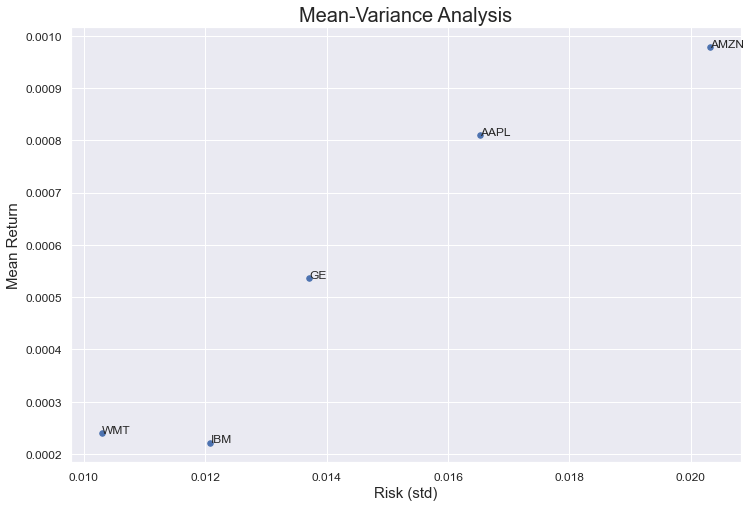

In [164]:
summary.plot(kind = "scatter", x="std", y="mean", figsize=(12,8), s=30, fontsize=12)
for i in summary.index:
    plt.annotate(i, xy=(summary.loc[i, "std"], summary.loc[i, "mean"]), size=12)
plt.xlabel("Risk (std)", fontsize=15)
plt.ylabel("Mean Return", fontsize=15)
plt.title("Mean-Variance Analysis", fontsize=20)
plt.show()

-> There is __no clear "best-performer"__ among ["WMT", "IBM", "GE", "AAPL", "AMZN"] (without further analysis). __Higher risk__ is getting rewarded with __higher returns__. __IBM underperformed__.

__Mean-Variance Analysis has one major shortcoming: It assumes that financial returns follow a Normal Distribution. That´s (typically) not True.<br> -> Standard Deviation of Returns underestimates the true/full risk of an Investment as it fails to measure "Tail Risks".__ 

 ## <font color=red>4.2.  Sharpe Ratio

__Which instrument(s) performed best/worst in the past in terms of risk & return? => Find the Annualized Sharpe Ratios for each stock in the portfolio__

The Sharpe Ratio is a measure for calculating risk-adjusted return, and this ratio has become the industry standard for such calculations. 

Sharpe ratio = (Mean portfolio return − Risk-free rate)/Standard deviation of portfolio return

The original Sharpe Ratio

Annualized Sharpe Ratio = K-value * SR

K-values for various sampling rates:

* Daily = sqrt(252)
* Weekly = sqrt(52)
* Monthly = sqrt(12)

I will use a very low risk-free rate (the rate you would get if you just put your money in a bank, its currently very low in the USA, let's just say its ~0% return). If you are in a different country with higher rates for your trading currency, you can use this trick to convert a yearly rate with a daily rate:

daily_rate = ((1.0 + yearly_rate)**(1/252))-1

Other values people use are things like the 3-month treasury bill or [LIBOR](http://www.investopedia.com/terms/l/libor.asp).

Read more: Sharpe Ratio http://www.investopedia.com/terms/s/sharperatio

In [165]:
def compute_sharpe_ratio(data, risk_free_rate=0):
    mean_return = data.pct_change(1).mean()
    std = data.pct_change(1).std()
    sharpe_ratio = (mean_return - risk_free_rate)/std
    
    return (252 ** 0.5) * sharpe_ratio

In [166]:
for stock in df.columns:
    print(f"{stock} Annualized Sharpe Ratio is: {compute_sharpe_ratio(df[stock])}")

AAPL Annualized Sharpe Ratio is: 0.9097845721358929
WMT Annualized Sharpe Ratio is: 0.45183837074200833
GE Annualized Sharpe Ratio is: 0.7292937725004837
AMZN Annualized Sharpe Ratio is: 0.9228855120825585
IBM Annualized Sharpe Ratio is: 0.3886566387826974


 ## <font color=red>4.3. Portfolio Values

In [167]:
stock_list = list(df.columns)
stock_list

['AAPL', 'WMT', 'GE', 'AMZN', 'IBM']

In [168]:
aapl = df[['AAPL']]
wmt = df[['WMT']]
ge = df[['GE']]
amzn = df[['AMZN']]
ibm = df[['IBM']]

In [169]:
aapl = df[['AAPL']]
aapl.head()

,AAPL
Date,
2010-01-04,6.535
2010-01-05,6.546
2010-01-06,6.442
2010-01-07,6.430
2010-01-08,6.473


### <font color=blue>1. Normalize Prices

In [170]:
for stock_df in (aapl, wmt, ibm, ge, amzn):
    stock_df.columns = ['Close']
    stock_df['Normed Return'] = stock_df['Close']/stock_df.iloc[0]['Close']

In [171]:
aapl.head()

,Close,Normed Return
Date,,
2010-01-04,6.535,1.000
2010-01-05,6.546,1.002
2010-01-06,6.442,0.986
2010-01-07,6.430,0.984
2010-01-08,6.473,0.991


In [172]:
aapl.tail()

,Close,Normed Return
Date,,
2016-12-23,27.344,4.184
2016-12-27,27.518,4.211
2016-12-28,27.401,4.193
2016-12-29,27.394,4.192
2016-12-30,27.180,4.159


### <font color=blue>2.  Allocations

Let's pretend we had the following allocations for our total portfolio:

* 30% in Apple
* 20% in WalMart
* 30% in IBM
* 10% in GE
* 10% in Amazon

Let's have these values be reflected by multiplying our Norme Return by out Allocations

In [193]:
for stock_df,allo in zip([aapl, wmt, ibm, ge, amzn],[.3,.2,.3,.1,.1]):
    stock_df['Allocation'] = stock_df['Normed Return']*allo

In [194]:
aapl.head()

,Close,Normed Return,Allocation,Position Values
Date,,,,
2010-01-04,6.535,1.000,0.300,300.000
2010-01-05,6.546,1.002,0.301,300.519
2010-01-06,6.442,0.986,0.296,295.738
2010-01-07,6.430,0.984,0.295,295.192
2010-01-08,6.473,0.991,0.297,297.154


### <font color=blue> 3.  Investment

Let's pretend we invested a million dollars in this portfolio

In [175]:
for stock_df in (aapl, wmt, ge, amzn, ibm):
    stock_df['Position Values'] = stock_df['Allocation']*1000

In [176]:
aapl.head()

,Close,Normed Return,Allocation,Position Values
Date,,,,
2010-01-04,6.535,1.000,0.300,300.000
2010-01-05,6.546,1.002,0.301,300.519
2010-01-06,6.442,0.986,0.296,295.738
2010-01-07,6.430,0.984,0.295,295.192
2010-01-08,6.473,0.991,0.297,297.154


### <font color=blue>4.  Total Portforlio Value

In [195]:
portfolio_val = pd.concat([aapl['Position Values'],wmt['Position Values'],ge['Position Values'],amzn['Position Values'],ibm['Position Values']],axis=1)
portfolio_val.columns = ['AAPL Pos','WMT Pos','GE Pos','AMZN Pos','IBM Pos']
portfolio_val['Total Pos'] = portfolio_val.sum(axis=1)
portfolio_val.head()

,AAPL Pos,WMT Pos,GE Pos,AMZN Pos,IBM Pos,Total Pos
Date,,,,,,
2010-01-04,300.000,200.000,100.000,100.000,300.000,1000.000
2010-01-05,300.519,198.008,100.518,100.590,296.376,996.011
2010-01-06,295.738,197.566,100.000,98.768,294.451,986.523
2010-01-07,295.192,197.677,105.178,97.087,293.431,988.565
2010-01-08,297.154,196.681,107.443,99.716,296.376,997.371


Text(0.5, 1.0, 'Total Portfolio Value')

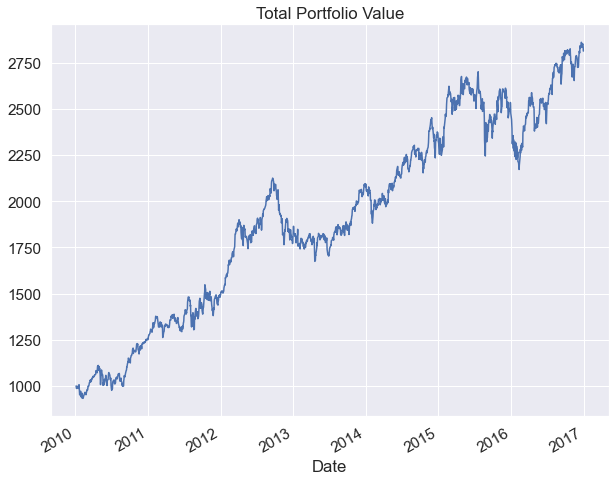

In [196]:
portfolio_val['Total Pos'].plot(figsize=(10,8))
plt.title('Total Portfolio Value')

<AxesSubplot:xlabel='Date'>

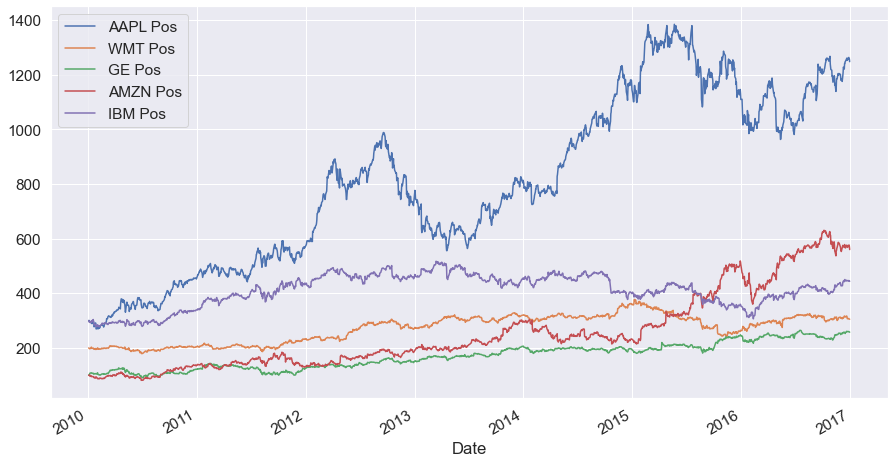

In [197]:
portfolio_val.drop('Total Pos',axis=1).plot(kind='line', figsize=(15,8))

### <font color=blue> 5. Portfolio Statisitcs

#### Daily Returns

In [180]:
portfolio_val['Daily Return'] = portfolio_val['Total Pos'].pct_change(1)

#### Cummulative Return

In [181]:
cum_ret = 100 * (portfolio_val['Total Pos'][-1]/portfolio_val['Total Pos'][0] -1 )
print('Our return {} was percent!'.format(cum_ret))

Our return 181.36427513192942 was percent!


#### Avg Daily Return

In [182]:
portfolio_val['Daily Return'].mean()

0.0006457476071089262

#### Std Daily Return

In [183]:
portfolio_val['Daily Return'].std()

0.010783207210004598

<AxesSubplot:ylabel='Density'>

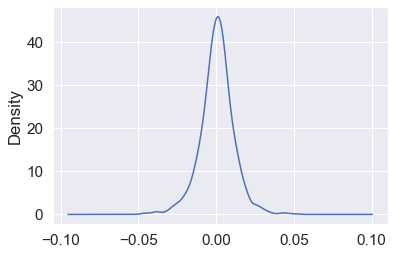

In [184]:
portfolio_val['Daily Return'].plot(kind='kde')

#### Sharpe Ratio

In [185]:
SR = portfolio_val['Daily Return'].mean()/portfolio_val['Daily Return'].std()

In [186]:
SR

0.059884558882426484

In [187]:
ASR = (252**0.5)*SR

In [188]:
ASR

0.9506379010542273

In [189]:
portfolio_val['Daily Return'].std()

0.010783207210004598

In [190]:
portfolio_val['Daily Return'].mean()

0.0006457476071089262

<AxesSubplot:ylabel='Density'>

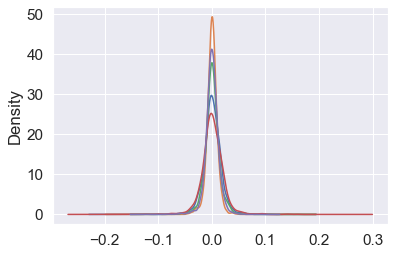

In [191]:
aapl['Close'].pct_change(1).plot(kind='kde')
wmt['Close'].pct_change(1).plot(kind='kde')
ge['Close'].pct_change(1).plot(kind='kde')
amzn['Close'].pct_change(1).plot(kind='kde')
ibm['Close'].pct_change(1).plot(kind='kde')

In [192]:
import numpy as np
np.sqrt(252)* (np.mean(.001-0.0002)/.001)

12.699606293110037

In [201]:
returns.head()

,AAPL,WMT,GE,AMZN,IBM
Date,,,,,
2010-01-04,NaN,NaN,NaN,NaN,NaN
2010-01-05,0.002,-0.010,0.005,0.006,-0.012
2010-01-06,-0.016,-0.002,-0.005,-0.018,-0.007
2010-01-07,-0.002,0.001,0.050,-0.017,-0.003
2010-01-08,0.007,-0.005,0.021,0.027,0.010


### <font color=blue>6. Covariance and Correlation

Do instruments/assets __move together__ (and to what extent)? <br>

Three cases:
- unrelated (__no__ relationship/correlation)
- moving together (__positive__ relationship/correlation)
- moving in opposite directions (__negative__ relationship/correlation) 

__-> Correlation between instruments/assets play an important role in portfolio management.__

In [198]:
returns.cov() # covariance (hard to interpret)

,AAPL,WMT,GE,AMZN,IBM
AAPL,0.000,0.000,0.000,0.000,0.000
WMT,0.000,0.000,0.000,0.000,0.000
GE,0.000,0.000,0.000,0.000,0.000
AMZN,0.000,0.000,0.000,0.000,0.000
IBM,0.000,0.000,0.000,0.000,0.000


In [199]:
returns.corr() # correlation coefficient (easy to interpret)

,AAPL,WMT,GE,AMZN,IBM
AAPL,1.000,0.230,0.383,0.329,0.383
WMT,0.230,1.000,0.366,0.204,0.313
GE,0.383,0.366,1.000,0.368,0.537
AMZN,0.329,0.204,0.368,1.000,0.346
IBM,0.383,0.313,0.537,0.346,1.000


Three cases:
- no correlation: __correlation coefficient == 0__
- moving together: __0 < correlation coefficient <= 1__ (positive)
- moving in opposite directions: __-1 <= correlation coefficient < 0__ (negative)

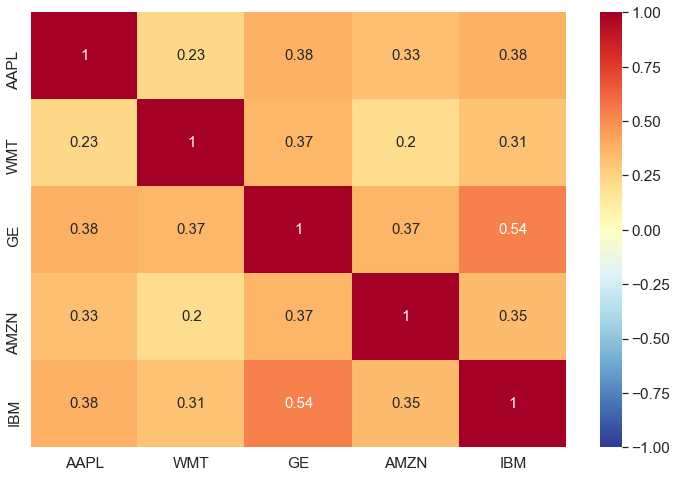

In [200]:
plt.figure(figsize=(12,8))
sns.set(font_scale=1.4)
sns.heatmap(returns.corr(), cmap = "RdYlBu_r", annot = True, annot_kws={"size":15}, vmin = -1, vmax = 1)
plt.show()

__Similar assets are (highly) positive correlated. Different assets exhibit low/no/negative correlation.__ <br>
-> In portfolio management it´s beneficial to have assets with low/no/negative correlation (portfolio diversification effect).

** Finally lets see if there is a relationship between these stocks, after all, they are all related to the car industry. We can see this easily through a scatter matrix plot. Import scatter_matrix from pandas.plotting and use it to create a scatter matrix plot of all the stocks'opening price. You may need to rearrange the columns into a new single dataframe. Hints and info can be found here: https://pandas.pydata.org/pandas-docs/stable/visualization.html#scatter-matrix-plot **

## Comparing Daily Returns between Stocks

** Create a scatter matrix plot to see the correlation between each of the stocks daily returns. This helps answer the questions of how related the car companies are. Is Tesla begin treated more as a technology company rather than a car company by the market?**

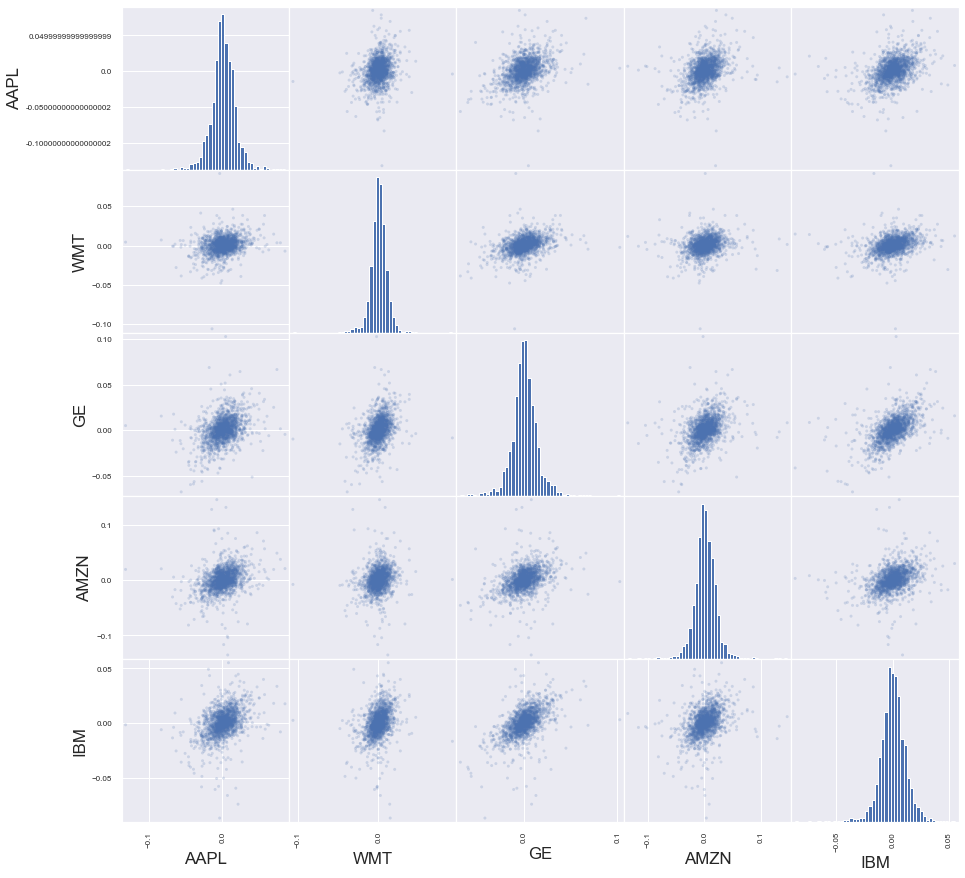

In [202]:
from pandas.plotting import scatter_matrix

# You can use a semi-colon to remove the axes print outs
scatter_matrix(returns,figsize=(15,15),alpha=0.2,hist_kwds={'bins':50});

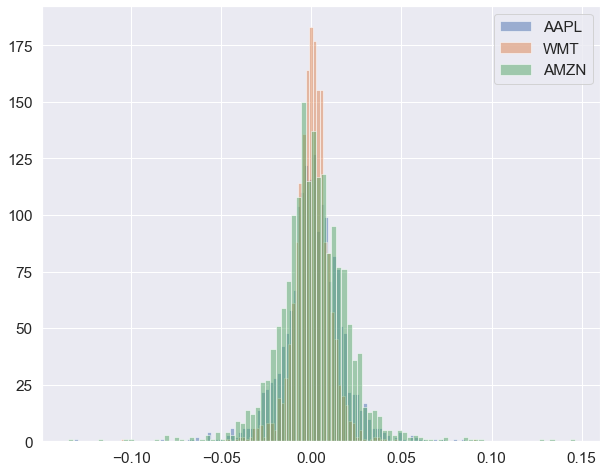

In [203]:
returns['AAPL'].hist(bins=100,label='AAPL',figsize=(10,8),alpha=0.5)
returns['WMT'].hist(bins=100,label='WMT',alpha=0.5)
returns['AMZN'].hist(bins=100,label='AMZN',alpha=0.5)
plt.legend()

** Try also plotting a KDE instead of histograms for another view point. Which stock has the widest plot? **

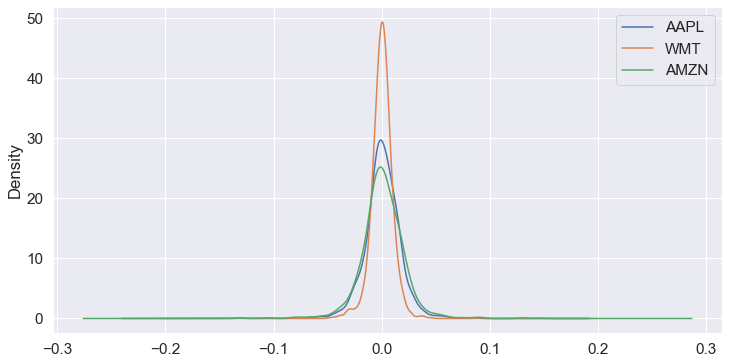

In [204]:
returns['AAPL'].plot(kind='kde',label='AAPL',figsize=(12,6))
returns['WMT'].plot(kind='kde',label='WMT')
returns['AMZN'].plot(kind='kde',label='AMZN')
plt.legend()

** Try also creating some box plots comparing the returns. **

<AxesSubplot:>

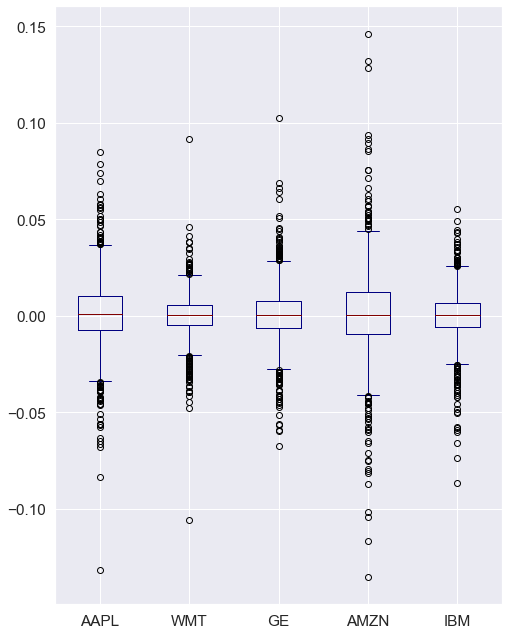

In [205]:
returns.plot(kind='box',figsize=(8,11),colormap='jet')

** It looks like Ford and GM do have some sort of possible relationship, let's plot just these two against eachother in scatter plot to view this more closely!**

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='AAPL', ylabel='IBM'>

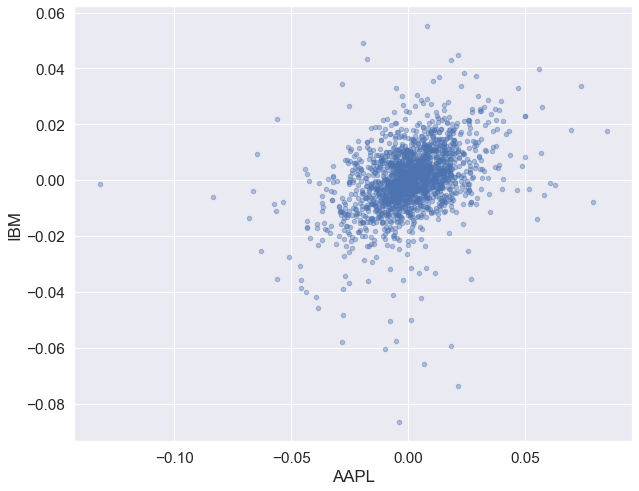

In [208]:
returns.plot(kind='scatter',x='AAPL',y='IBM',alpha=0.4,figsize=(10,8))

In some countries (and for some instruments like stocks) short selling is prohibited. <br>
Most intuitive/popular use case for short selling: __Currencies (Forex)__

---
# <div class="alert alert-info"> 5. PORTFOLIO OPTIMIZATION </div>

## <font color=red>5. 1. Markowitz Model</font>

“Modern Portfolio Theory (MPT), a hypothesis put forth by Harry Markowitz in his paper “Portfolio Selection,” (published in 1952 by the Journal of Finance) is an investment theory based on the idea that risk-averse investors can construct portfolios to optimize or maximize expected return based on a given level of market risk, emphasizing that risk is an inherent part of higher reward. It is one of the most important and influential economic theories dealing with finance and investment.


 ### <font color=blue>1. Monte Carlo Simulation for Optimization Search

We could randomly try to find the optimal portfolio balance using Monte Carlo simulation

In [209]:
df.head()

,AAPL,WMT,GE,AMZN,IBM
Date,,,,,
2010-01-04,6.535,40.658,87.554,6.695,83.321
2010-01-05,6.546,40.253,88.008,6.734,82.314
2010-01-06,6.442,40.163,87.554,6.613,81.780
2010-01-07,6.430,40.186,92.088,6.500,81.497
2010-01-08,6.473,39.983,94.071,6.676,82.314


In [210]:
mean_daily_ret = df.pct_change(1).mean()
mean_daily_ret

AAPL   0.001
WMT    0.000
GE     0.001
AMZN   0.001
IBM    0.000
dtype: float64

In [211]:
df.pct_change(1).corr()

,AAPL,WMT,GE,AMZN,IBM
AAPL,1.000,0.230,0.382,0.328,0.385
WMT,0.230,1.000,0.364,0.203,0.314
GE,0.382,0.364,1.000,0.365,0.536
AMZN,0.328,0.203,0.365,1.000,0.346
IBM,0.385,0.314,0.536,0.346,1.000


 ### <font color=blue>2. Simulating Thousands of Possible Allocations

<AxesSubplot:xlabel='Date'>

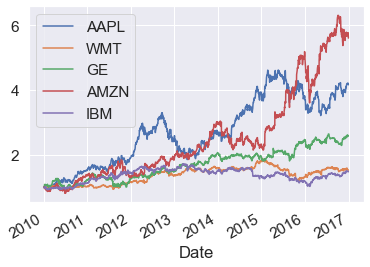

In [212]:
stock_normed = df/df.iloc[0]
stock_normed.plot()

In [213]:
stock_daily_ret = df.pct_change(1)
stock_daily_ret.head()

,AAPL,WMT,GE,AMZN,IBM
Date,,,,,
2010-01-04,NaN,NaN,NaN,NaN,NaN
2010-01-05,0.002,-0.010,0.005,0.006,-0.012
2010-01-06,-0.016,-0.002,-0.005,-0.018,-0.006
2010-01-07,-0.002,0.001,0.052,-0.017,-0.003
2010-01-08,0.007,-0.005,0.022,0.027,0.010


 ### <font color=blue>3. Log Returns vs Arithmetic Returns

We will now switch over to using log returns instead of arithmetic returns, for many of our use cases they are almost the same,but most technical analyses require detrending/normalizing the time series and using log returns is a nice way to do that.
Log returns are convenient to work with in many of the algorithms we will encounter.

For a full analysis of why we use log returns, check [this great article](https://quantivity.wordpress.com/2011/02/21/why-log-returns/).


In [214]:
log_ret = np.log(df/df.shift(1))
log_ret.head()

,AAPL,WMT,GE,AMZN,IBM
Date,,,,,
2010-01-04,NaN,NaN,NaN,NaN,NaN
2010-01-05,0.002,-0.010,0.005,0.006,-0.012
2010-01-06,-0.016,-0.002,-0.005,-0.018,-0.007
2010-01-07,-0.002,0.001,0.050,-0.017,-0.003
2010-01-08,0.007,-0.005,0.021,0.027,0.010


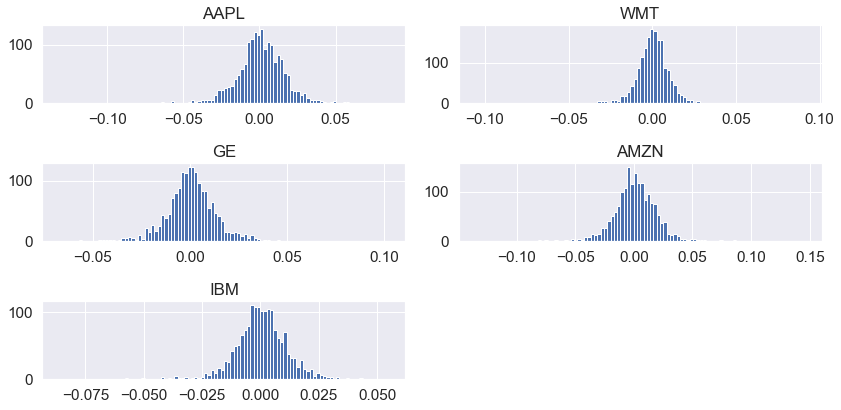

In [215]:
log_ret.hist(bins=100,figsize=(12,6));
plt.tight_layout()

In [216]:
log_ret.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
AAPL,1761.000,0.001,0.017,-0.132,-0.007,0.001,0.010,0.085
WMT,1761.000,0.000,0.010,-0.106,-0.005,0.001,0.006,0.091
GE,1761.000,0.001,0.014,-0.068,-0.006,0.000,0.008,0.103
AMZN,1761.000,0.001,0.020,-0.135,-0.009,0.001,0.012,0.146
IBM,1761.000,0.000,0.012,-0.086,-0.006,0.000,0.007,0.055


In [217]:
log_ret.mean() * 252

AAPL   0.204
WMT    0.060
GE     0.135
AMZN   0.247
IBM    0.056
dtype: float64

In [218]:
# Compute pairwise covariance of columns
log_ret.cov()

,AAPL,WMT,GE,AMZN,IBM
AAPL,0.000,0.000,0.000,0.000,0.000
WMT,0.000,0.000,0.000,0.000,0.000
GE,0.000,0.000,0.000,0.000,0.000
AMZN,0.000,0.000,0.000,0.000,0.000
IBM,0.000,0.000,0.000,0.000,0.000


In [219]:
log_ret.cov()*252 # multiply by days

,AAPL,WMT,GE,AMZN,IBM
AAPL,0.069,0.010,0.022,0.028,0.019
WMT,0.010,0.027,0.013,0.011,0.010
GE,0.022,0.013,0.047,0.026,0.022
AMZN,0.028,0.011,0.026,0.104,0.021
IBM,0.019,0.010,0.022,0.021,0.037


 ### <font color=blue>4. Single Run for Some Random Allocation

In [220]:
# Set seed (optional)
np.random.seed(101)

# Stock Columns
print('Stocks')
print(df.columns)
print('\n')

# Create Random Weights
print('Creating Random Weights')
weights = np.array(np.random.random(5))
print(weights)
print('\n')

# Rebalance Weights
print('Rebalance to sum to 1.0')
weights = weights / np.sum(weights)
print(weights)
print('\n')

# Expected Return
print('Expected Portfolio Return')
exp_ret = np.sum(log_ret.mean() * weights) *252
print(exp_ret)
print('\n')

# Expected Variance
print('Expected Volatility')
exp_vol = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov() * 252, weights)))
print(exp_vol)
print('\n')

# Sharpe Ratio
SR = exp_ret/exp_vol
print('Sharpe Ratio')
print(SR)


Stocks
Index(['AAPL', 'WMT', 'GE', 'AMZN', 'IBM'], dtype='object')


Creating Random Weights
[0.51639863 0.57066759 0.02847423 0.17152166 0.68527698]


Rebalance to sum to 1.0
[0.26182041 0.28933544 0.01443678 0.08696357 0.3474438 ]


Expected Portfolio Return
0.11369288001744317


Expected Volatility
0.15109584097717582


Sharpe Ratio
0.7524553904472946


 ### <font color=blue>5. run this many times over!

In [221]:
num_ports = 15000

all_weights = np.zeros((num_ports,len(df.columns)))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)

for ind in range(num_ports):

    # Create Random Weights
    weights = np.array(np.random.random(5))

    # Rebalance Weights
    weights = weights / np.sum(weights)
    
    # Save Weights
    all_weights[ind,:] = weights

    # Expected Return
    ret_arr[ind] = np.sum((log_ret.mean() * weights) *252)

    # Expected Variance
    vol_arr[ind] = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov() * 252, weights)))

    # Sharpe Ratio
    sharpe_arr[ind] = ret_arr[ind]/vol_arr[ind]

In [222]:
sharpe_arr.max()

0.9693614211263939

In [223]:
sharpe_arr.argmax()

7989

In [224]:
all_weights[sharpe_arr.argmax(),:]

array([0.37293814, 0.12952867, 0.1703862 , 0.32461974, 0.00252726])

In [225]:
max_sr_ret = ret_arr[sharpe_arr.argmax()]
max_sr_vol = vol_arr[sharpe_arr.argmax()]

 ### <font color=blue>6.  Plotting the data

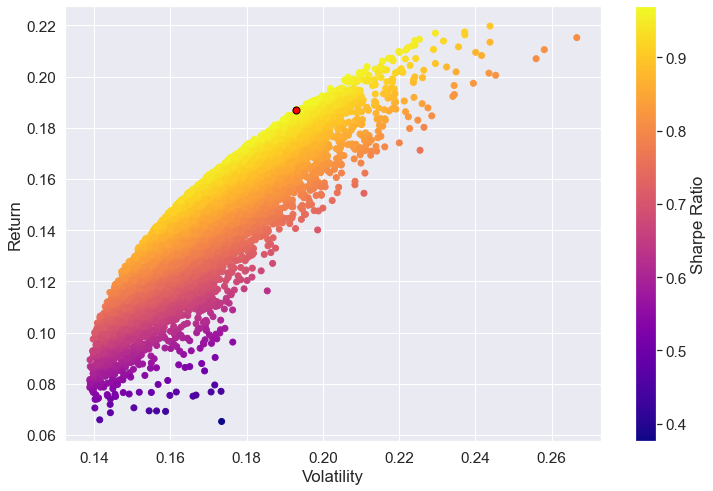

In [226]:
plt.figure(figsize=(12,8))
plt.scatter(vol_arr,ret_arr,c=sharpe_arr,cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')

# Add red dot for max SR
plt.scatter(max_sr_vol,max_sr_ret,c='red',s=50,edgecolors='black')

 ### <font color=blue>7.  Mathematical Optimization

There are much better ways to find good allocation weights than just guess and check! We can use optimization functions to find the ideal weights mathematically!

#### Functionalize Return and SR operations

In [227]:
def get_ret_vol_sr(weights):
    """
    Takes in weights, returns array or return,volatility, sharpe ratio
    """
    weights = np.array(weights)
    ret = np.sum(log_ret.mean() * weights) * 252
    vol = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov() * 252, weights)))
    sr = ret/vol
    return np.array([ret,vol,sr])

In [228]:
from scipy.optimize import minimize

In [229]:
help(minimize)

Help on function minimize in module scipy.optimize._minimize:

minimize(fun, x0, args=(), method=None, jac=None, hess=None, hessp=None, bounds=None, constraints=(), tol=None, callback=None, options=None)
    Minimization of scalar function of one or more variables.
    
    Parameters
    ----------
    fun : callable
        The objective function to be minimized.
    
            ``fun(x, *args) -> float``
    
        where ``x`` is an 1-D array with shape (n,) and ``args``
        is a tuple of the fixed parameters needed to completely
        specify the function.
    x0 : ndarray, shape (n,)
        Initial guess. Array of real elements of size (n,),
        where 'n' is the number of independent variables.
    args : tuple, optional
        Extra arguments passed to the objective function and its
        derivatives (`fun`, `jac` and `hess` functions).
    method : str or callable, optional
        Type of solver.  Should be one of
    
            - 'Nelder-Mead' :ref:`(see her

Optimization works as a minimization function, since we actually want to maximize the Sharpe Ratio, we will need to turn it negative so we can minimize the negative sharpe (same as maximizing the postive sharpe)

In [230]:
def neg_sharpe(weights):
    return  get_ret_vol_sr(weights)[2] * -1

In [231]:
# Contraints
def check_sum(weights):
    '''
    Returns 0 if sum of weights is 1.0
    '''
    return np.sum(weights) - 1

In [232]:
# By convention of minimize function it should be a function that returns zero for conditions
cons = ({'type':'eq','fun': check_sum})

In [233]:
# 0-1 bounds for each weight
bounds = ((0, 1), (0, 1), (0, 1), (0, 1), (0, 1))

In [234]:
# Initial Guess (equal distribution)
init_guess = [0.2,0.2,0.2,0.2,0.2]

In [235]:
# Sequential Least SQuares Programming (SLSQP).
opt_results = minimize(neg_sharpe,init_guess,method='SLSQP',bounds=bounds,constraints=cons)

In [236]:
opt_results

     fun: -0.9709671257520202
     jac: array([-9.14931297e-06,  8.44895840e-06, -5.95301390e-06,  1.29789114e-05,
        2.10737988e-01])
 message: 'Optimization terminated successfully'
    nfev: 42
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([3.97683436e-01, 8.70958813e-02, 1.99808688e-01, 3.15411995e-01,
       4.49910020e-17])

In [237]:
np.round(opt_results.x,3)

array([0.398, 0.087, 0.2  , 0.315, 0.   ])

In [238]:
get_ret_vol_sr(opt_results.x)

array([0.19116927, 0.19688542, 0.97096713])

 ### <font color=blue>8. All Optimal Portfolios (Efficient Frontier)

The efficient frontier is the set of optimal portfolios that offers the highest expected return for a defined level of risk or the lowest risk for a given level of expected return. Portfolios that lie below the efficient frontier are sub-optimal, because they do not provide enough return for the level of risk. Portfolios that cluster to the right of the efficient frontier are also sub-optimal, because they have a higher level of risk for the defined rate of return.

Efficient Frontier http://www.investopedia.com/terms/e/efficientfrontier

In [239]:
# Our returns go from 0 to somewhere along 0.3
# Create a linspace number of points to calculate x on
frontier_y = np.linspace(0.06,0.25,100) # Change 100 to a lower number for slower computers!

In [240]:
def minimize_volatility(weights):
    return  get_ret_vol_sr(weights)[1] 

In [241]:
frontier_volatility = []

for possible_return in frontier_y:
    # function for return
    cons = ({'type':'eq','fun': check_sum},
            {'type':'eq','fun': lambda w: get_ret_vol_sr(w)[0] - possible_return})
    
    result = minimize(minimize_volatility,init_guess,method='SLSQP',bounds=bounds,constraints=cons)
    
    frontier_volatility.append(result['fun'])

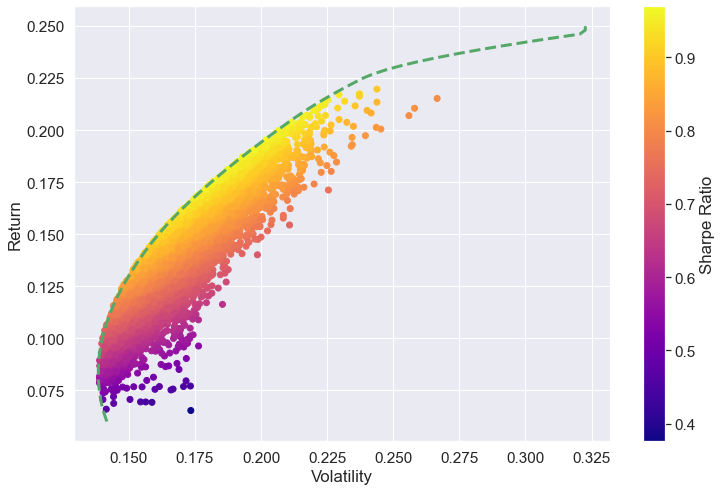

In [242]:
plt.figure(figsize=(12,8))
plt.scatter(vol_arr,ret_arr,c=sharpe_arr,cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')



# Add frontier line
plt.plot(frontier_volatility,frontier_y,'g--',linewidth=3)

 ### <font color=blue>9. Define all functions

In [243]:
    
def calculate_return(data):
    # NORMALIZATION - to measure all variables in comparable metric
    log_return = np.log(data / data.shift(1))
    return log_return[1:]


def show_statistics(returns):
    # instead of daily metrics we are after annual metrics
    # mean of annual returns
    print(returns.mean() * NUM_TRADING_DAYS)
    print(returns.cov() * NUM_TRADING_DAYS)


def show_mean_variance(returns, weights):
    # we are after the annual return
    portfolio_return = np.sum(returns.mean() * weights) * NUM_TRADING_DAYS
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * NUM_TRADING_DAYS, weights)))
    
    
def show_portfolios(returns, volatilities):
    plt.figure(figsize=(10, 6))
    plt.scatter(volatilities, returns, c=returns/volatilities, marker='o')
    plt.grid(True)
    plt.xlabel('Expected Volatility')
    plt.ylabel('Expected Return')
    plt.colorbar(label='Sharpe Ratio')
    plt.show()
    
    
def generate_portfolios(returns):
    portfolio_means = []
    portfolio_risks = []
    portfolio_weights = []
    
    for _ in range(NUM_PORTFOLIOS):
        w = np.random.random(len(stocks))
        w /= np.sum(w)
        portfolio_weights.append(w)
        portfolio_means.append(np.sum(returns.mean() * w) * NUM_TRADING_DAYS)
        portfolio_risks.append(np.sqrt(np.dot(w.T, np.dot(returns.cov()
                                                          * NUM_TRADING_DAYS, w))))

    return np.array(portfolio_weights), np.array(portfolio_means), np.array(portfolio_risks)


def statistics(weights, returns):
    portfolio_return = np.sum(returns.mean() * weights) * NUM_TRADING_DAYS
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov()
                                                            * NUM_TRADING_DAYS, weights)))
    return np.array([portfolio_return, portfolio_volatility,
                     portfolio_return / portfolio_volatility])


# scipy optimize module can find the minimum of a given function
# the maximum of a f(x) is the minimum of -f(x)
def min_function_sharpe(weights, returns):
    return -statistics(weights, returns)[2]


# what are the constraints? The sum of weights = 1 !!!
# f(x)=0 this is the function to minimize
def optimize_portfolio(weights, returns):
    # the sum of weights is 1
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    # the weights can be 1 at most: 1 when 100% of money is invested into a single stock
    bounds = tuple((0, 1) for _ in range(len(stocks)))
    return optimization.minimize(fun=min_function_sharpe, x0=weights[0], args=returns
                                 , method='SLSQP', bounds=bounds, constraints=constraints)


def print_optimal_portfolio(optimum, returns):
    print("Optimal portfolio: ", optimum['x'].round(3))
    print("Expected return, volatility and Sharpe ratio: ",
          statistics(optimum['x'].round(3), returns))


def show_optimal_portfolio(opt, rets, portfolio_rets, portfolio_vols):
    plt.figure(figsize=(10, 6))
    plt.scatter(portfolio_vols, portfolio_rets, c=portfolio_rets / portfolio_vols, marker='o')
    plt.grid(True)
    plt.xlabel('Expected Volatility')
    plt.ylabel('Expected Return')
    plt.colorbar(label='Sharpe Ratio')
    plt.plot(statistics(opt['x'], rets)[1], statistics(opt['x'], rets)[0], 'g*', markersize=20.0)
    plt.show()

In [244]:
log_daily_returns = calculate_return(dataset)
show_statistics(log_daily_returns)

AAPL   0.204
WMT    0.060
GE     0.135
AMZN   0.247
IBM    0.056
dtype: float64
      AAPL   WMT    GE  AMZN   IBM
AAPL 0.069 0.010 0.022 0.028 0.019
WMT  0.010 0.027 0.013 0.011 0.010
GE   0.022 0.013 0.047 0.026 0.022
AMZN 0.028 0.011 0.026 0.104 0.021
IBM  0.019 0.010 0.022 0.021 0.037


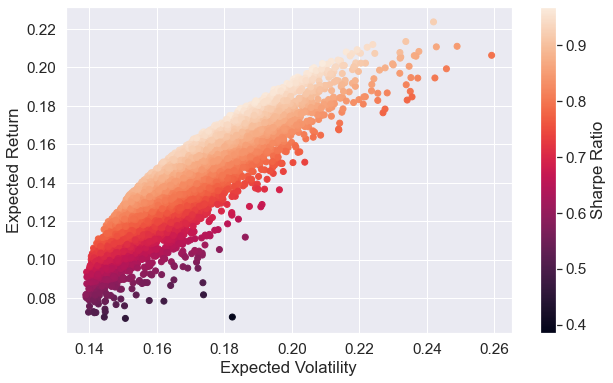

In [245]:
pweights, means, risks = generate_portfolios(log_daily_returns)
show_portfolios(means, risks)

Optimal portfolio:  [0.398 0.087 0.2   0.315 0.   ]
Expected return, volatility and Sharpe ratio:  [0.19115237 0.19686806 0.97096692]


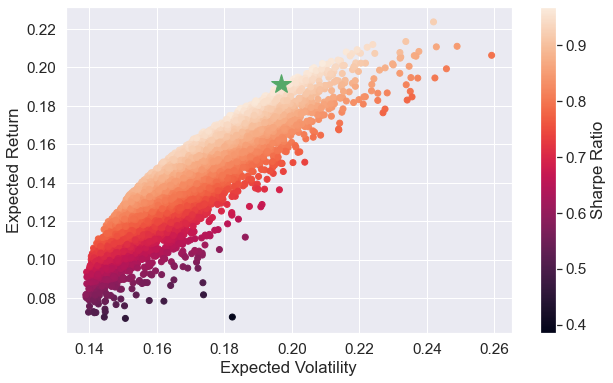

In [246]:
optimum = optimize_portfolio(pweights, log_daily_returns)
print_optimal_portfolio(optimum, log_daily_returns)
show_optimal_portfolio(optimum, log_daily_returns, means, risks)

## <font color=red>5.2. CAPM - Capital Asset Pricing Model</font>


 ### <font color=blue> 1. Introduction
    
#### Portfolio Returns:

### $r_p(t) = \sum\limits_{i}^{n}w_i r_i(t)$

#### Market Weights:

### $ w_i = \frac{MarketCap_i}{\sum_{j}^{n}{MarketCap_j}} $

#### CAPM of a portfolio

### $ r_p(t) = \beta_pr_m(t) + \sum\limits_{i}^{n}w_i \alpha_i(t)$

In [247]:
from scipy import stats

# Model CAPM as a simple linear regression
help(stats.linregress)

Help on function linregress in module scipy.stats._stats_mstats_common:

linregress(x, y=None)
    Calculate a linear least-squares regression for two sets of measurements.
    
    Parameters
    ----------
    x, y : array_like
        Two sets of measurements.  Both arrays should have the same length.  If
        only `x` is given (and ``y=None``), then it must be a two-dimensional
        array where one dimension has length 2.  The two sets of measurements
        are then found by splitting the array along the length-2 dimension.  In
        the case where ``y=None`` and `x` is a 2x2 array, ``linregress(x)`` is
        equivalent to ``linregress(x[0], x[1])``.
    
    Returns
    -------
    slope : float
        Slope of the regression line.
    intercept : float
        Intercept of the regression line.
    rvalue : float
        Correlation coefficient.
    pvalue : float
        Two-sided p-value for a hypothesis test whose null hypothesis is
        that the slope is zero, 

 ### <font color=blue> 2. Download data

In [248]:
import pandas_datareader as web

start = pd.to_datetime('2010-01-04')
end = pd.to_datetime('2017-07-18')

aapl = web.DataReader('AAPL','yahoo',start,end)
spy_etf = web.DataReader('SPY','yahoo',start,end)

aapl.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,7.661,7.585,7.622,7.643,493729600.000,6.535
2010-01-05,7.700,7.616,7.664,7.656,601904800.000,6.546
2010-01-06,7.687,7.527,7.656,7.535,552160000.000,6.442
2010-01-07,7.571,7.466,7.562,7.521,477131200.000,6.430
2010-01-08,7.571,7.466,7.511,7.571,447610800.000,6.473


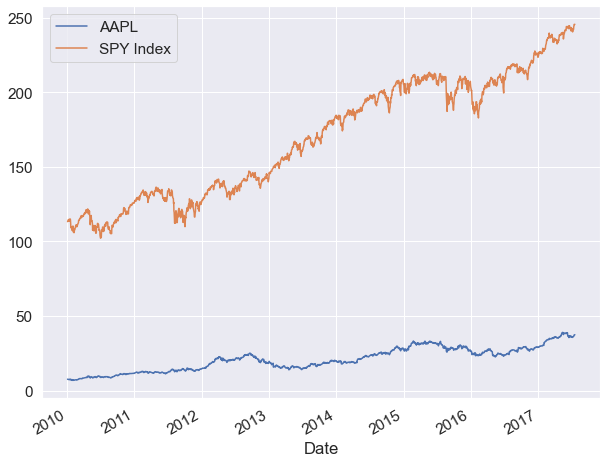

In [249]:
aapl['Close'].plot(label='AAPL',figsize=(10,8))
spy_etf['Close'].plot(label='SPY Index')
plt.legend()

 ### <font color=blue>3. Compare Cumulative Return

In [250]:
aapl['Cumulative'] = aapl['Close']/aapl['Close'].iloc[0]
spy_etf['Cumulative'] = spy_etf['Close']/spy_etf['Close'].iloc[0]

Text(0.5, 1.0, 'Cumulative Return')

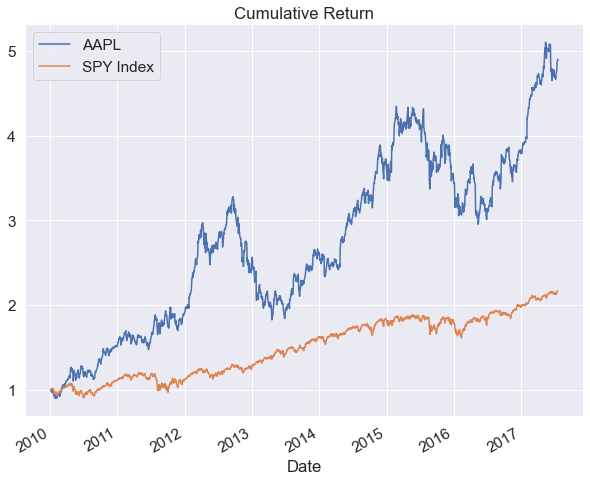

In [251]:
aapl['Cumulative'].plot(label='AAPL',figsize=(10,8))
spy_etf['Cumulative'].plot(label='SPY Index')
plt.legend()
plt.title('Cumulative Return')

### <font color=blue>4. Get Daily Return

In [252]:
aapl['Daily Return'] = aapl['Close'].pct_change(1)
spy_etf['Daily Return'] = spy_etf['Close'].pct_change(1)

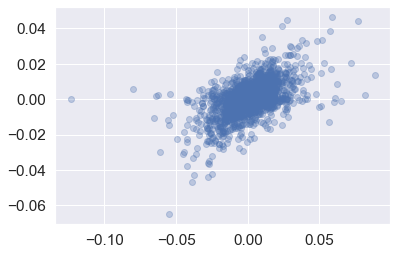

In [253]:
plt.scatter(aapl['Daily Return'],spy_etf['Daily Return'],alpha=0.3)

<AxesSubplot:>

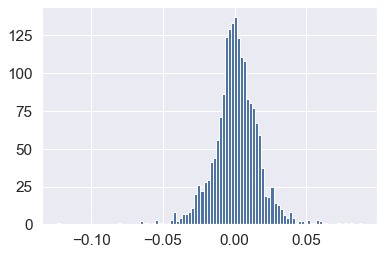

In [254]:
aapl['Daily Return'].hist(bins=100)

<AxesSubplot:>

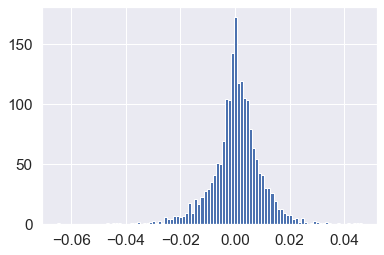

In [255]:
spy_etf['Daily Return'].hist(bins=100)

In [256]:
beta,alpha,r_value,p_value,std_err = stats.linregress(aapl['Daily Return'].iloc[1:],spy_etf['Daily Return'].iloc[1:])

In [257]:
beta

0.32571851289420134

In [258]:
alpha

0.0001369931113453333

In [259]:
r_value

0.5556582033773628

 ### <font color=blue> 6. What if our stock was completely related to SP500?

In [260]:
spy_etf['Daily Return'].head()

Date
2010-01-04     NaN
2010-01-05   0.003
2010-01-06   0.001
2010-01-07   0.004
2010-01-08   0.003
Name: Daily Return, dtype: float64

In [261]:
import numpy as np

In [262]:
noise = np.random.normal(0,0.001,len(spy_etf['Daily Return'].iloc[1:]))

In [263]:
noise

array([-0.00087603, -0.00025926,  0.00019219, ..., -0.0001992 ,
        0.00014675,  0.00028623])

In [264]:
spy_etf['Daily Return'].iloc[1:] + noise

Date
2010-01-05   0.002
2010-01-06   0.000
2010-01-07   0.004
2010-01-08   0.003
2010-01-11   0.001
              ... 
2017-07-12   0.007
2017-07-13   0.003
2017-07-14   0.004
2017-07-17   0.000
2017-07-18   0.001
Name: Daily Return, Length: 1897, dtype: float64

In [265]:
beta,alpha,r_value,p_value,std_err = stats.linregress(spy_etf['Daily Return'].iloc[1:]+noise,spy_etf['Daily Return'].iloc[1:])

In [266]:
beta

0.9913233785159324

In [267]:
alpha

-2.481986492110027e-05

Looks like our understanding is correct!

 ### <font color=blue>7.  OOP

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Beta from formula:  0.7135102325813049
Beta from regression:  0.7135102325813046
Expected return:  0.090113149990387


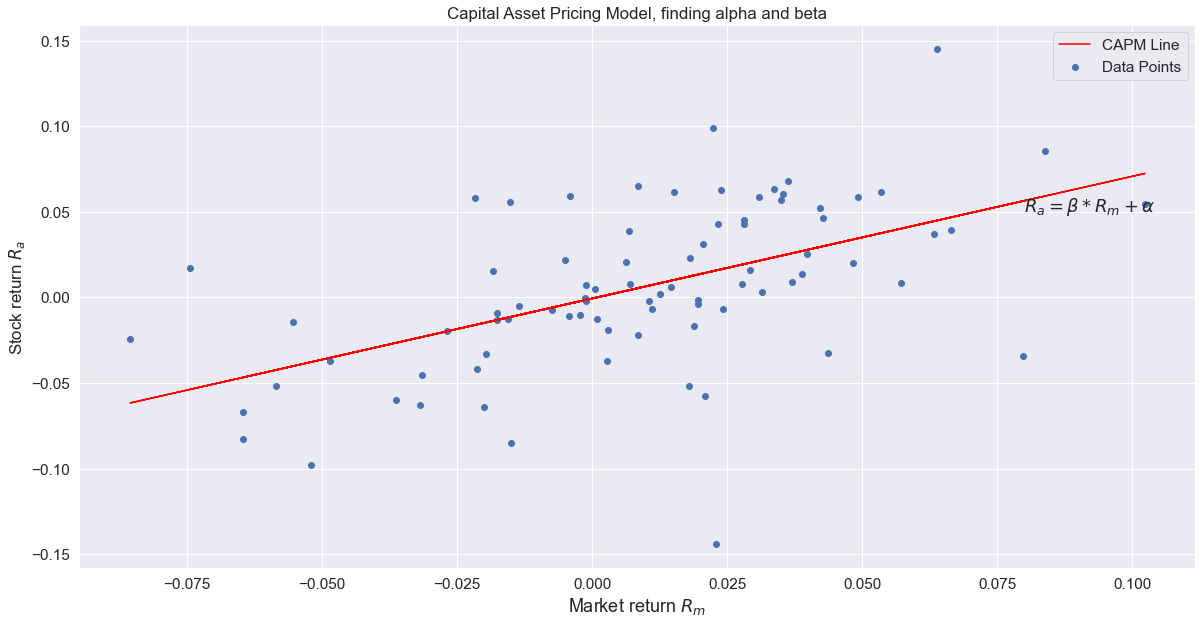

In [268]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# market interest rate
RISK_FREE_RATE = 0.05
# we will consider monthly returns - and we want to calculate the annual return
MONTHS_IN_YEAR = 12

class CAPM:

    def __init__(self, stocks, start_date, end_date):
        self.data = None
        self.stocks = stocks
        self.start_date = start_date
        self.end_date = end_date

    def download_data(self):
        data = {}

        for stock in self.stocks:
            ticker = yf.download(stock, self.start_date, self.end_date)
            data[stock] = ticker['Adj Close']

        return pd.DataFrame(data)

    def initialize(self):
        stock_data = self.download_data()
        # we use monthly returns instead of daily returns
        stock_data = stock_data.resample('M').last()

        self.data = pd.DataFrame({'s_adjclose': stock_data[self.stocks[0]],
                                  'm_adjclose': stock_data[self.stocks[1]]})

        # logarithmic monthly returns
        self.data[['s_returns', 'm_returns']] = np.log(self.data[['s_adjclose', 'm_adjclose']] /
                                                       self.data[['s_adjclose', 'm_adjclose']].shift(1))

        # remove the NaN values
        self.data = self.data[1:]

    def calculate_beta(self):
        # covariance matrix: the diagonal items are the variances
        # off diagonals are the covariances
        # the matrix is symmetric: cov[0,1] = cov[1,0] !!!
        covariance_matrix = np.cov(self.data["s_returns"], self.data["m_returns"])
        # calculating beta according to the formula
        beta = covariance_matrix[0, 1] / covariance_matrix[1, 1]
        print("Beta from formula: ", beta)

    def regression(self):
        # using linear regression to fit a line to the data
        # [stock_returns, market_returns] - slope is the beta
        beta, alpha = np.polyfit(self.data['m_returns'], self.data['s_returns'], deg=1)
        print("Beta from regression: ", beta)
        # calculate the expected return according to the CAPM formula
        # we are after annual return (this is why multiply by 12)
        expected_return = RISK_FREE_RATE + beta * (self.data['m_returns'].mean()*MONTHS_IN_YEAR
                                                   - RISK_FREE_RATE)
        print("Expected return: ", expected_return)
        self.plot_regression(alpha, beta)

    def plot_regression(self, alpha, beta):
        fig, axis = plt.subplots(1, figsize=(20, 10))
        axis.scatter(self.data["m_returns"], self.data['s_returns'],
                     label="Data Points")
        axis.plot(self.data["m_returns"], beta * self.data["m_returns"] + alpha,
                  color='red', label="CAPM Line")
        plt.title('Capital Asset Pricing Model, finding alpha and beta')
        plt.xlabel('Market return $R_m$', fontsize=18)
        plt.ylabel('Stock return $R_a$')
        plt.text(0.08, 0.05, r'$R_a = \beta * R_m + \alpha$', fontsize=18)
        plt.legend()
        plt.grid(True)
        plt.show()
        
        
capm = CAPM(['IBM', '^GSPC'], '2010-01-01', '2017-01-01')
capm.initialize()
capm.calculate_beta()
capm.regression()